## 빅데이터 활용 AI 설계
# Seq2seq Eng-Fra Translater
- 제너레이터 적용하여 전체 문장 로딩

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import string
from string import digits
import re

### 영어-불어 번역 파일 불러오기

In [34]:
df= pd.read_csv('fra.txt', delimiter='\t', names=['eng', 'fr'])

In [35]:
df.head()

,eng,fr
0,Go.,Va !
1,Run!,Cours !
2,Run!,Courez !
3,Wow!,Ça alors !
4,Fire!,Au feu !


In [36]:
df.tail()

,eng,fr
149856,A carbon footprint is the amount of carbon dio...,Une empreinte carbone est la somme de pollutio...
149857,Death is something that we're often discourage...,La mort est une chose qu'on nous décourage sou...
149858,Since there are usually multiple websites on a...,Puisqu'il y a de multiples sites web sur chaqu...
149859,If someone who doesn't know your background sa...,Si quelqu'un qui ne connaît pas vos antécédent...
149860,It may be impossible to get a completely error...,Il est peut-être impossible d'obtenir un Corpu...


In [37]:
df.shape

(149861, 2)

### 전체 문장 사용

In [60]:
### 전체 문장 사용시 CPU 에러 발생!!! (내부 텐서 사용시 단어사전 차원이 커서 발생하는 듯)

#lines = df[:10000].copy()
lines = df.copy()
lines.shape

(149861, 2)

In [61]:
lines.tail()

,eng,fr
149856,A carbon footprint is the amount of carbon dio...,Une empreinte carbone est la somme de pollutio...
149857,Death is something that we're often discourage...,La mort est une chose qu'on nous décourage sou...
149858,Since there are usually multiple websites on a...,Puisqu'il y a de multiples sites web sur chaqu...
149859,If someone who doesn't know your background sa...,Si quelqu'un qui ne connaît pas vos antécédent...
149860,It may be impossible to get a completely error...,Il est peut-être impossible d'obtenir un Corpu...


### 데이터 정리

In [62]:
lines.eng=lines.eng.apply(lambda x: x.lower())
lines.fr=lines.fr.apply(lambda x: x.lower())

lines.eng=lines.eng.apply(lambda x: re.sub("'", '', x)).apply(lambda x: re.sub(",", ' COMMA', x))
lines.fr=lines.fr.apply(lambda x: re.sub("'", '', x)).apply(lambda x: re.sub(",", ' COMMA', x))

exclude = set(string.punctuation) # '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
lines.eng=lines.eng.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
lines.fr=lines.fr.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

# 숫자를 지운다
remove_digits = str.maketrans('', '', digits)
lines.eng=lines.eng.apply(lambda x: x.translate(remove_digits))
lines.fr=lines.fr.apply(lambda x: x.translate(remove_digits))

### 불어 문장에 태그 달기
- START_ 와 _END

In [63]:
lines.fr = lines.fr.apply(lambda x : 'START_ '+ x + ' _END')

In [64]:
lines.head()

,eng,fr
0,go,START_ va _END
1,run,START_ cours _END
2,run,START_ courez _END
3,wow,START_ ça alors _END
4,fire,START_ au feu _END


### 단어 목록 만들기

In [65]:
eng_words=set()
for eng in lines.eng:
    for word in eng.split():
        eng_words.add(word)
    
fra_words=set()
for fr in lines.fr:
    for word in fr.split():
        fra_words.add(word)

In [66]:
eng_words = sorted(list(eng_words))
fra_words = sorted(list(fra_words))

len(eng_words), len(fra_words)

(13799, 27980)

In [67]:
display(eng_words[:10], fra_words[:10])

['COMMA',
 'a',
 'aback',
 'abacus',
 'abandon',
 'abandoned',
 'abandoning',
 'abated',
 'abdominal',
 'abducted']

['COMMA',
 'COMMAenfila',
 'START_',
 '_END',
 'a',
 'abaissa',
 'abaisse',
 'abaisser',
 'abaissez',
 'abaissé']

### 단어 사전 만들기

In [68]:
eng_w2i = { word: i for i, word in enumerate(eng_words) }
fra_w2i = { word: i for i, word in enumerate(fra_words) }

eng_i2w = { i: word for word, i in eng_w2i.items() }
fra_i2w = { i: word for word, i in fra_w2i.items() }

In [69]:
len(eng_i2w), len(fra_i2w)

(13799, 27980)

### 최대 문장 길이

In [70]:
eng_sen_max = max([len(sen.split()) for sen in lines.eng])
fra_sen_max = max([len(sen.split()) for sen in lines.fr])

eng_sen_max, fra_sen_max

(49, 58)

### 인코더  생성

In [71]:
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Dense

In [72]:
embedding_size = 50

enc_inputs = Input((eng_sen_max,))
enc_embed = Embedding(len(eng_words),embedding_size)(enc_inputs)

enc_lstm = LSTM(50, return_state=True)
enc_output, state_h, state_c = enc_lstm(enc_embed)

enc_states = [state_h, state_c]

### 디코더 생성

In [73]:
dec_inputs = Input((fra_sen_max,))
dec_embed = Embedding(len(fra_words), embedding_size)(dec_inputs)

dec_lstm = LSTM(50, return_sequences=True)
dec_outputs = dec_lstm(dec_embed, initial_state=enc_states)

dec_outputs = Dense(len(fra_words), activation='softmax')(dec_outputs)

In [74]:
model = Model([enc_inputs, dec_inputs], dec_outputs)

In [75]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])

In [76]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 49)           0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 58)           0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 49, 50)       689950      input_5[0][0]                    
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 58, 50)       1399000     input_6[0][0]                    
__________________________________________________________________________________________________
lstm_5 (LS

### 입출력 제너레이터

In [55]:
'''encoder_input_data = np.zeros([len(lines), eng_sen_max])
decoder_input_data = np.zeros([len(lines), fra_sen_max])
decoder_output_data = np.zeros([len(lines), fra_sen_max, len(fra_words)])'''

'encoder_input_data = np.zeros([len(lines), eng_sen_max])\ndecoder_input_data = np.zeros([len(lines), fra_sen_max])\ndecoder_output_data = np.zeros([len(lines), fra_sen_max, len(fra_words)])'

In [56]:
'''for line, (eng,fra) in enumerate(zip(lines.eng, lines.fr)):
    for t, word in enumerate(eng.split()):
        encoder_input_data[line,t] = eng_w2i[word]
        
    for t, word in enumerate(fra.split()):
        decoder_input_data[line,t] = fra_w2i[word]
        if t>0:
            decoder_output_data[line,t-1,fra_w2i[word]] = 1 # START_ 가 빠지고 하나씩 당겨짐'''

'for line, (eng,fra) in enumerate(zip(lines.eng, lines.fr)):\n    for t, word in enumerate(eng.split()):\n        encoder_input_data[line,t] = eng_w2i[word]\n        \n    for t, word in enumerate(fra.split()):\n        decoder_input_data[line,t] = fra_w2i[word]\n        if t>0:\n            decoder_output_data[line,t-1,fra_w2i[word]] = 1 # START_ 가 빠지고 하나씩 당겨짐'

In [57]:
def generate_batch(X = lines.eng, y = lines.fr, batch_size = 128):
    while True:
        for j in range(0, len(X), batch_size):
            
            encoder_input_data = np.zeros((batch_size, eng_sen_max),dtype='float32') # (128,34)
            decoder_input_data = np.zeros((batch_size, fra_sen_max),dtype='float32') # (128,37)
            decoder_output_data = np.zeros((batch_size, fra_sen_max, len(fra_words)),dtype='float32')
            
            for i, (eng, fra) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(eng.split()):
                    encoder_input_data[i, t] = eng_w2i[word]
                    
                for t, word in enumerate(fra.split()):
                    decoder_input_data[i, t] = fra_w2i[word]
                    if t>0: # 앞부분 'START_' 제외
                        decoder_output_data[i, t - 1, fra_w2i[word]] = 1
                        
            yield([encoder_input_data, decoder_input_data], decoder_output_data)

### 학습 시키기

In [58]:
'''h = model.fit([encoder_input_data, decoder_input_data], decoder_output_data,
              batch_size=128, epochs=10, validation_split=0.1)'''

'h = model.fit([encoder_input_data, decoder_input_data], decoder_output_data,\n              batch_size=128, epochs=10, validation_split=0.1)'

In [77]:
model.fit_generator(generator = generate_batch(lines.eng, lines.fr, batch_size = 128),
                    steps_per_epoch = len(lines)//128,
                    epochs=1)

Epoch 1/1


ResourceExhaustedError: OOM when allocating tensor with shape[7424,27980] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node dense_3/MatMul}} = MatMul[T=DT_FLOAT, _class=["loc:@training_2/RMSprop/gradients/dense_3/MatMul_grad/MatMul"], transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/device:CPU:0"](dense_3/Reshape, dense_3/kernel/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


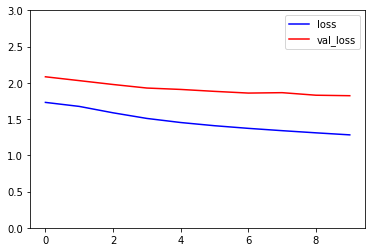

In [150]:
plt.plot(h.history['loss'], 'b-')
plt.plot(h.history['val_loss'], 'r-')
plt.ylim(0,3)
plt.legend(['loss', 'val_loss'])

In [151]:
h2 = model.fit([encoder_input_data, decoder_input_data], decoder_output_data,
              batch_size=128, epochs=120, validation_split=0.1)

Train on 9000 samples, validate on 1000 samples
Epoch 1/120
9000/9000 [==============================] - 191s 21ms/step - loss: 1.2554 - acc: 0.1240 - val_loss: 1.8178 - val_acc: 0.1112
Epoch 2/120
9000/9000 [==============================] - 152s 17ms/step - loss: 1.2295 - acc: 0.1268 - val_loss: 1.8049 - val_acc: 0.1108
Epoch 3/120
9000/9000 [==============================] - 159s 18ms/step - loss: 1.2050 - acc: 0.1295 - val_loss: 1.7932 - val_acc: 0.1116
Epoch 4/120
9000/9000 [==============================] - 150s 17ms/step - loss: 1.1811 - acc: 0.1321 - val_loss: 1.7891 - val_acc: 0.1135
Epoch 5/120
9000/9000 [==============================] - 154s 17ms/step - loss: 1.1580 - acc: 0.1353 - val_loss: 1.7669 - val_acc: 0.1174
Epoch 6/120
9000/9000 [==============================] - 162s 18ms/step - loss: 1.1362 - acc: 0.1376 - val_loss: 1.7494 - val_acc: 0.1208
Epoch 7/120
9000/9000 [==============================] - 156s 17ms/step - loss: 1.1156 - acc: 0.1418 - val_loss: 1.7430 - va

Epoch 118/120
9000/9000 [==============================] - 148s 16ms/step - loss: 0.4068 - acc: 0.2398 - val_loss: 1.7885 - val_acc: 0.1358
Epoch 119/120
9000/9000 [==============================] - 149s 17ms/step - loss: 0.4047 - acc: 0.2400 - val_loss: 1.8014 - val_acc: 0.1353
Epoch 120/120
9000/9000 [==============================] - 148s 16ms/step - loss: 0.4024 - acc: 0.2402 - val_loss: 1.7896 - val_acc: 0.1352


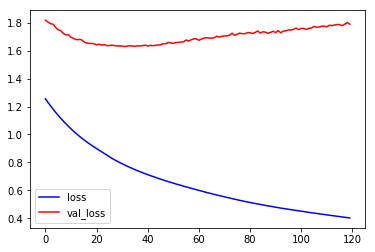

In [153]:
plt.plot(h2.history['loss'], 'b-')
plt.plot(h2.history['val_loss'], 'r-')
#plt.ylim(0,3)
plt.legend(['loss', 'val_loss'])

In [154]:
model.save('eng_fra_word_model.h5')
model.save_weights('eng_fra_word_weights.h5')
np.savez('eng_fra_word_history.npz', [h.history, h2.history])

C:\Anaconda3\envs\py36\lib\site-packages\keras\engine\network.py:877: UserWarning: Layer lstm_6 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_5/while/Exit_3:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'lstm_5/while/Exit_4:0' shape=(?, 50) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


### 번역하기

In [3]:
s = 'I love you'
l = s.lower().split()
l = [word for word in l if word in eng_words][:eng_sen_max]

### 영어 입력
eng_text = np.zeros([1,eng_sen_max])
for t,word in enumerate(l):
    eng_text[0,t] = eng_w2i[word]

### 불어 입력
fra_text = np.zeros([1,fra_sen_max])
fra_text[0,0] = fra_w2i['START_']
result = []

for i in range(fra_sen_max):
    pred_y = model.predict([eng_text,fra_text])[0,i]
    
    idx = np.argmax(pred_y)
    word = fra_i2w[idx]
    result.append(word)
    
    if word=='_END' or i==(fra_sen_max-1): break
        
    fra_text[0,i+1] = idx
    
display(s,l,' '.join(result))

NameError: name 'eng_words' is not defined